## **Unzipping and reading the data**

In [12]:
import zipfile
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## **The data is randomly split into training, validation and testing**

In [14]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Training data: {}, Validation Data: {}, Testing Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

##Exporting the dataset 
test_data.to_csv("TestData.csv")
val_data.to_csv("ValidationData.csv")

Training data: 5937, Validation Data: 1979, Testing Data: 1980


## **Function to plot the learning curve of the training**

In [15]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## **Defining a default model to be inspired from for the baseline models**
As the size of the images are 27 x 27, and the there are 4 different target variable types for the variable cellType, the parameters for the MLP as set accordingly.

In [16]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [17]:
# Importing the tensorflow package to be able to use keras libary 
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.12.0'

In [18]:
#Setting up the basic sequential model to setup all the layers to be used later for the actual models.
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM), #using Flatten to transform 2d array to 1d array 
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'), 
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [19]:
#Compiling the model using loss function, optimizer and the evaluation metrics
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [20]:
# Covnerting the labels to string format for the ImageDataGenerator be able to read it
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [21]:
# Using ImageDataGenerator to load the data in batches to memory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [22]:
# Using model.fit() to train the model
history = model.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

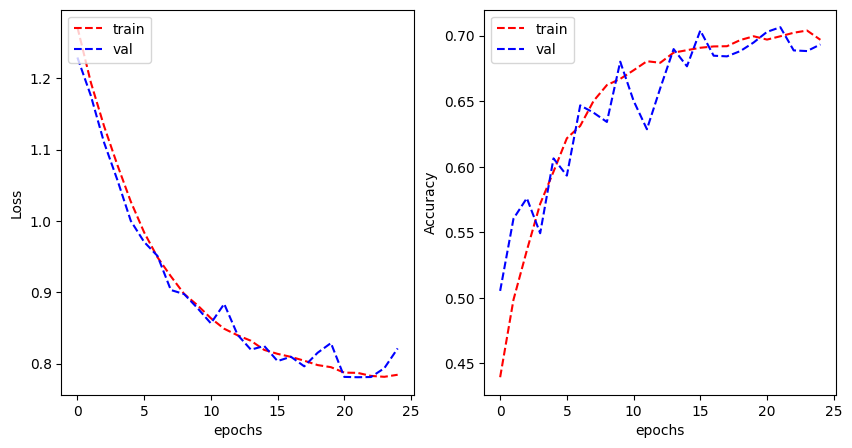

In [23]:
#Plotting the learning curve to visualise the metric results
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [24]:
# Rescaling the test data and creating a data generator to get the test data
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [25]:
model.evaluate(test_generator)

1980/1980 [==============================] - 7s 4ms/step - loss: 0.8478 - categorical_accuracy: 0.6732


[0.8478306531906128, 0.6732323169708252]

## **Visualizing the network output for the default model by plotting the results**

In [95]:
# Defining the label names:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

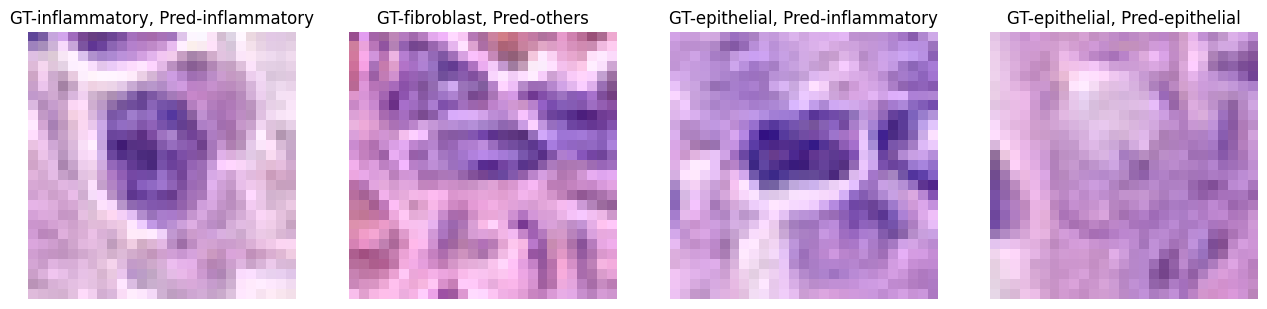

In [96]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## **Determining the goals for the task :**
Now that we have already setup a default model for the parameters and metrics to be used from, we can start making the basline models. We are going to compare two baseline models VGG and ResNeT to begin with and improve on the model which provides better results. 

**Using VGG in Task 1 has already proven to be giving good results. Hence, experimenting the same model here may prove to be reward fetching.**

In [28]:
#Basic VGG sequential model
baseline_VGG = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation = 'softmax'),
])

baseline_VGG.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_baseline_VGG = baseline_VGG.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


186/186 [==============================] - 10s 31ms/step - loss: 1.1825 - categorical_accuracy: 0.4858 - val_loss: 0.9090 - val_categorical_accuracy: 0.6054
Epoch 2/100
186/186 [==============================] - 5s 25ms/step - loss: 0.8586 - categorical_accuracy: 0.6572 - val_loss: 0.8044 - val_categorical_accuracy: 0.6751
Epoch 3/100
186/186 [==============================] - 4s 22ms/step - loss: 0.7498 - categorical_accuracy: 0.7051 - val_loss: 0.6569 - val_categorical_accuracy: 0.7423
Epoch 4/100
186/186 [==============================] - 5s 28ms/step - loss: 0.7000 - categorical_accuracy: 0.7325 - val_loss: 0.6608 - val_categorical_accuracy: 0.7433
Epoch 5/100
186/186 [==============================] - 4s 23ms/step - loss: 0.6648 - categorical_accuracy: 0.7438 - val_loss: 0.6343 - val_categorical_accuracy: 0.7554
Epoch 6/100
186/186 [==============================] - 5s 26ms/step - loss: 0.6376 - categorical_accuracy: 0.7583 - val_loss: 0.7564 - val_categorical_accuracy: 0.7019
Epo

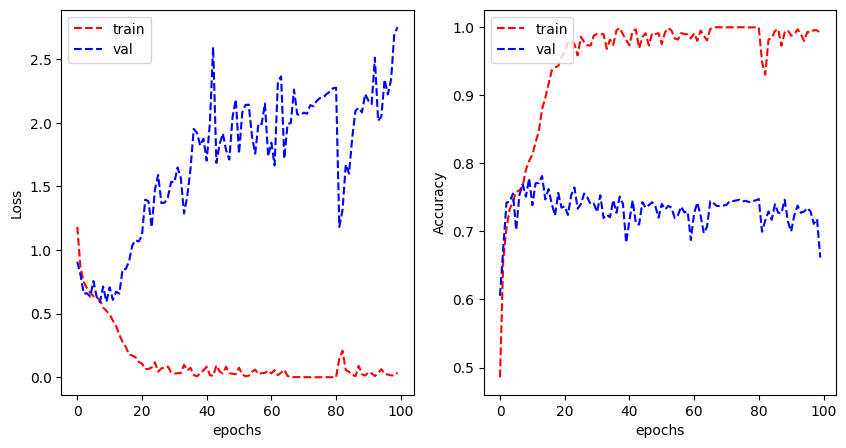

In [29]:
plot_learning_curve(history_baseline_VGG.history['loss'], history_baseline_VGG.history['val_loss'], 
                    history_baseline_VGG.history['categorical_accuracy'], history_baseline_VGG.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [30]:
baseline_VGG.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 2.7065 - categorical_accuracy: 0.6657


[2.706455945968628, 0.665656566619873]

**Using ResNet to compare results for two different CNN models**

In [31]:
# Exploring a basic CNN model ResNet18 as an alernative approach to see the difference of results
baseline_RCCNet18 = tf.keras.Sequential([
    
    #RCC block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #RCC block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

baseline_RCCNet18.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_baseline_RCCNet18 = baseline_RCCNet18.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)



Epoch 1/100
186/186 [==============================] - 7s 26ms/step - loss: 1.2356 - categorical_accuracy: 0.4521 - val_loss: 0.8498 - val_categorical_accuracy: 0.6559
Epoch 2/100
186/186 [==============================] - 4s 22ms/step - loss: 0.8194 - categorical_accuracy: 0.6769 - val_loss: 0.7859 - val_categorical_accuracy: 0.6953
Epoch 3/100
186/186 [==============================] - 5s 25ms/step - loss: 0.7274 - categorical_accuracy: 0.7142 - val_loss: 0.6803 - val_categorical_accuracy: 0.7413
Epoch 4/100
186/186 [==============================] - 4s 24ms/step - loss: 0.6899 - categorical_accuracy: 0.7270 - val_loss: 0.6664 - val_categorical_accuracy: 0.7367
Epoch 5/100
186/186 [==============================] - 4s 24ms/step - loss: 0.6534 - categorical_accuracy: 0.7468 - val_loss: 0.6944 - val_categorical_accuracy: 0.7191
Epoch 6/100
186/186 [==============================] - 5s 26ms/step - loss: 0.6192 - categorical_accuracy: 0.7630 - val_loss: 0.7927 - val_categorical_accuracy:

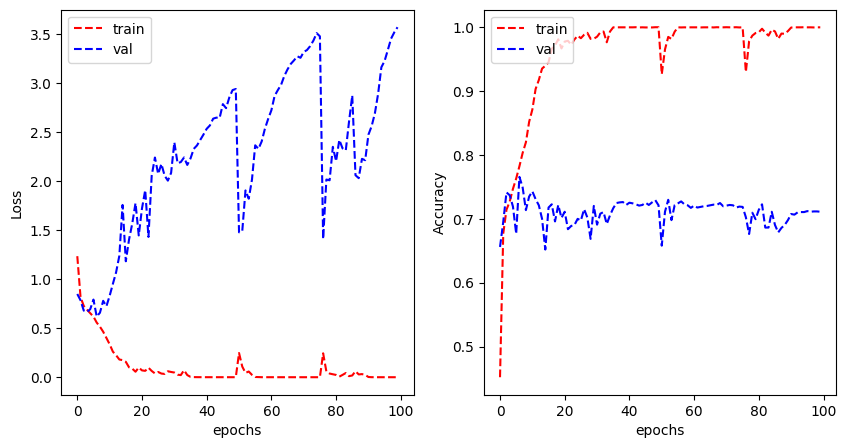

In [32]:
plot_learning_curve(history_baseline_RCCNet18.history['loss'], history_baseline_RCCNet18.history['val_loss'], 
                    history_baseline_RCCNet18.history['categorical_accuracy'], history_baseline_RCCNet18.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [33]:
baseline_RCCNet18.evaluate(test_generator)

1980/1980 [==============================] - 8s 4ms/step - loss: 4.2206 - categorical_accuracy: 0.6919


[4.22062873840332, 0.691919207572937]

## Choosing the baseline VGG model for data augmentation and regularization  for improvization as it provided better results than baseline ResNet

In [34]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.5,
                                   height_shift_range=0.5, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [35]:
reg_lambda = 0.001

VGG_model_regularized = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])

VGG_model_regularized.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_VGG_model_regularized = VGG_model_regularized.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


186/186 [==============================] - 12s 51ms/step - loss: 1.3899 - categorical_accuracy: 0.4307 - val_loss: 1.1481 - val_categorical_accuracy: 0.4866
Epoch 2/100
186/186 [==============================] - 9s 50ms/step - loss: 1.2247 - categorical_accuracy: 0.4686 - val_loss: 1.1494 - val_categorical_accuracy: 0.5068
Epoch 3/100
186/186 [==============================] - 8s 45ms/step - loss: 1.1759 - categorical_accuracy: 0.4981 - val_loss: 1.0290 - val_categorical_accuracy: 0.5584
Epoch 4/100
186/186 [==============================] - 8s 45ms/step - loss: 1.1589 - categorical_accuracy: 0.4945 - val_loss: 1.0737 - val_categorical_accuracy: 0.5240
Epoch 5/100
186/186 [==============================] - 10s 52ms/step - loss: 1.1756 - categorical_accuracy: 0.4866 - val_loss: 1.1089 - val_categorical_accuracy: 0.4881
Epoch 6/100
186/186 [==============================] - 10s 52ms/step - loss: 1.1191 - categorical_accuracy: 0.5225 - val_loss: 0.9657 - val_categorical_accuracy: 0.5841
E

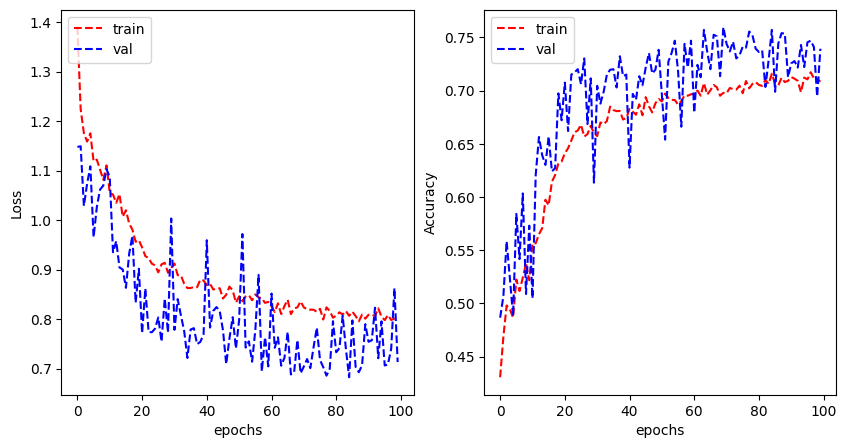

In [36]:
plot_learning_curve(history_VGG_model_regularized.history['loss'], history_VGG_model_regularized.history['val_loss'], 
                    history_VGG_model_regularized.history['categorical_accuracy'], history_VGG_model_regularized.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [81]:
VGG_model_regularized.evaluate(test_generator)

1980/1980 [==============================] - 8s 4ms/step - loss: 0.7752 - categorical_accuracy: 0.7157


[0.7751776576042175, 0.715656578540802]

### **Using Dropout on existing VGG Model (augmented and regularized)**

In [38]:
reg_lambda = 0.001

VGG_model_dropout = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])

VGG_model_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_VGG_model_dropout = VGG_model_dropout.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)


Epoch 1/100
186/186 [==============================] - 12s 47ms/step - loss: 1.4426 - categorical_accuracy: 0.4184 - val_loss: 1.1968 - val_categorical_accuracy: 0.4608
Epoch 2/100
186/186 [==============================] - 10s 52ms/step - loss: 1.2192 - categorical_accuracy: 0.4656 - val_loss: 1.0803 - val_categorical_accuracy: 0.5306
Epoch 3/100
186/186 [==============================] - 9s 50ms/step - loss: 1.2105 - categorical_accuracy: 0.4640 - val_loss: 1.1784 - val_categorical_accuracy: 0.5174
Epoch 4/100
186/186 [==============================] - 9s 47ms/step - loss: 1.1395 - categorical_accuracy: 0.5065 - val_loss: 1.0597 - val_categorical_accuracy: 0.5073
Epoch 5/100
186/186 [==============================] - 8s 45ms/step - loss: 1.1225 - categorical_accuracy: 0.5161 - val_loss: 1.0193 - val_categorical_accuracy: 0.5932
Epoch 6/100
186/186 [==============================] - 9s 47ms/step - loss: 1.0924 - categorical_accuracy: 0.5245 - val_loss: 1.0309 - val_categorical_accurac

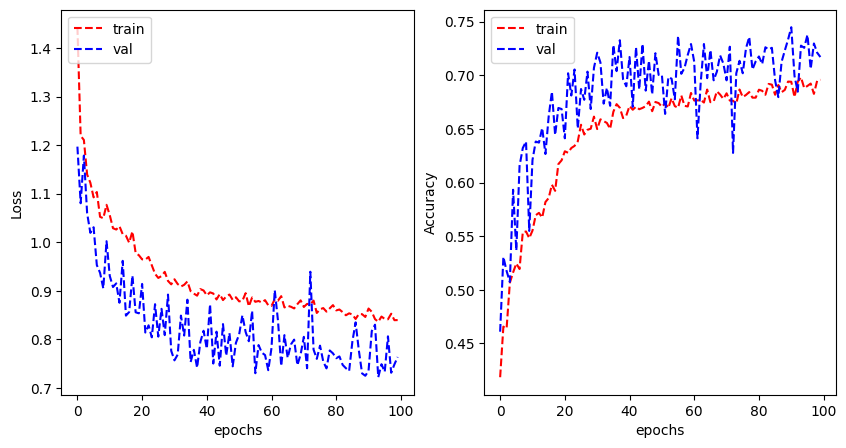

In [39]:
plot_learning_curve(history_VGG_model_dropout.history['loss'], history_VGG_model_dropout.history['val_loss'], 
                    history_VGG_model_dropout.history['categorical_accuracy'], history_VGG_model_dropout.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [82]:
VGG_model_dropout.evaluate(test_generator)

1980/1980 [==============================] - 8s 4ms/step - loss: 0.8030 - categorical_accuracy: 0.7025


[0.8030380010604858, 0.70252525806427]

### **Using the unlabeled data *data_labels_extraData.csv* to improve the performance of the model**

In [52]:
extra_data = pd.read_csv('./data_labels_extraData.csv')
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [ ]:
# select predictions with 0.99 prediction probabilities
image_size = (27, 27)
data_to_append = pd.DataFrame()
for index,img in extra_data.iterrows():
    img = tf.keras.preprocessing.image.load_img(
        "./patch_images/"+img['ImageName'], target_size=image_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = VGG_model_dropout.predict(img_array)
    if max(predictions[0]) > 0.99 :
        data_to_append = data_to_append.append(extra_data.loc[index],ignore_index = True)
        data_to_append.loc[index,'cellType'] = list(predictions[0]).index(max(predictions[0]))
        
data_to_append

In [ ]:
# label the data according to the predictions made
label_names = {'0.0' : 'fibroblast', '1.0': 'inflammatory', '2.0':'epithelial','3.0' : 'others'}
for index, image in data_to_append.iterrows():
    data_to_append.loc[index,'cellTypeName'] = label_names.get(str(image['cellType']))
data_to_append

In [53]:
# remove null values if any
data_to_append = data_to_append.dropna().reset_index().drop(columns = 'index')

In [54]:
# combined old training data with the new labeled data
new_train_data = train_data.append(data_to_append).reset_index().drop(columns='index')

<ipython-input-54-3e557dde99d9>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_data = train_data.append(data_to_append).reset_index().drop(columns='index')


In [55]:
new_train_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [56]:
new_train_data['cellType'] = new_train_data['cellType'].astype('int')

In [57]:
set(new_train_data['cellType'])

{0, 1, 2, 3}

In [58]:
# generate training and validation data
new_train_data['cellType'] = new_train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.5,
                                   height_shift_range=0.5, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=new_train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 15379 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [63]:
# Using the same model paramteres as VGG_model_dropout 
reg_lambda = 0.001

VGG_model_final = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])

VGG_model_final.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_VGG_model_final = VGG_model_final.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Epoch 1/100
481/481 [==============================] - 26s 47ms/step - loss: 1.2295 - categorical_accuracy: 0.4461 - val_loss: 1.4628 - val_categorical_accuracy: 0.4093
Epoch 2/100
481/481 [==============================] - 23s 47ms/step - loss: 1.0795 - categorical_accuracy: 0.5053 - val_loss: 1.2264 - val_categorical_accuracy: 0.4351
Epoch 3/100
481/481 [==============================] - 22s 46ms/step - loss: 0.9855 - categorical_accuracy: 0.5876 - val_loss: 1.0293 - val_categorical_accuracy: 0.6043
Epoch 4/100
481/481 [==============================] - 23s 47ms/step - loss: 0.9059 - categorical_accuracy: 0.6498 - val_loss: 1.1668 - val_categorical_accuracy: 0.5240
Epoch 5/100
481/481 [==============================] - 22s 46ms/step - loss: 0.8758 - categorical_accuracy: 0.6697 - val_loss: 1.0774 - val_categorical_accuracy: 0.5594
Epoch 6/100
481/481 [==============================] - 23s 47ms/step - loss: 0.8484 - categorical_accuracy: 0.6818 - val_loss: 0.9764 - val_categorical_acc

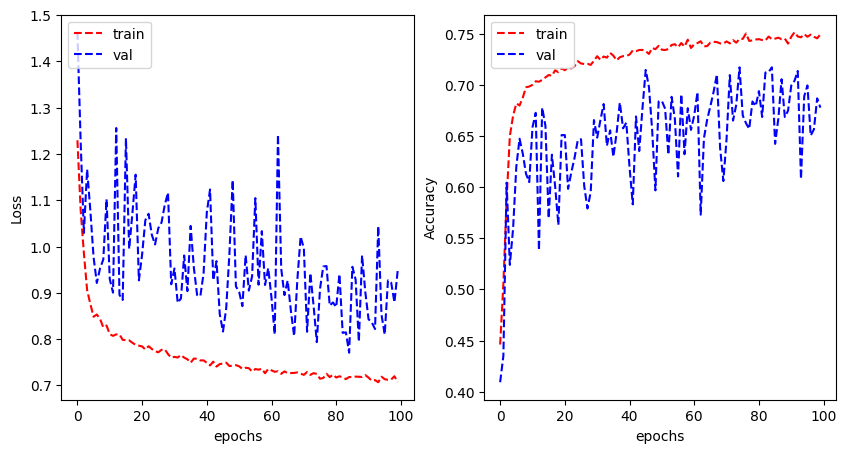

In [64]:
plot_learning_curve(history_VGG_model_final.history['loss'], history_VGG_model_final.history['val_loss'], 
                    history_VGG_model_final.history['categorical_accuracy'], history_VGG_model_final.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [83]:
VGG_model_final.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 0.9645 - categorical_accuracy: 0.6707


[0.964490532875061, 0.6707070469856262]

In [92]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

Found 1980 validated image filenames belonging to 4 classes.


In [93]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = VGG_model_regularized.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all,y_hat_all))

Accuracy score:  0.7156565656565657
F1 score:  0.6420704158145139
[[160  73  40 118]
 [  5 418  20  53]
 [ 17  58 713   3]
 [ 17 118  41 126]]
              precision    recall  f1-score   support

           0       0.80      0.41      0.54       391
           1       0.63      0.84      0.72       496
           2       0.88      0.90      0.89       791
           3       0.42      0.42      0.42       302

    accuracy                           0.72      1980
   macro avg       0.68      0.64      0.64      1980
weighted avg       0.73      0.72      0.71      1980



In [91]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = VGG_model_dropout.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all,y_hat_all))

Accuracy score:  0.7025252525252526
F1 score:  0.6068852524737146
[[155 147  62  27]
 [  9 457  21   9]
 [  4  77 710   0]
 [ 16 175  42  69]]
              precision    recall  f1-score   support

           0       0.84      0.40      0.54       391
           1       0.53      0.92      0.68       496
           2       0.85      0.90      0.87       791
           3       0.66      0.23      0.34       302

    accuracy                           0.70      1980
   macro avg       0.72      0.61      0.61      1980
weighted avg       0.74      0.70      0.68      1980



In [87]:
for x,y in test_generator:
        y_hat = VGG_model_final.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all,y_hat_all))

Accuracy score:  0.6707070707070707
F1 score:  0.5971890889681217
[[135  83  75  98]
 [  1 435  15  45]
 [  2 135 650   4]
 [ 11 151  32 108]]
              precision    recall  f1-score   support

           0       0.91      0.35      0.50       391
           1       0.54      0.88      0.67       496
           2       0.84      0.82      0.83       791
           3       0.42      0.36      0.39       302

    accuracy                           0.67      1980
   macro avg       0.68      0.60      0.60      1980
weighted avg       0.72      0.67      0.66      1980

